In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import LeakyReLU 

In [4]:
bs = 64
iz = 256

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Leaf_Images",            #this is the name of the folder
    
    shuffle = True,           #it will shuffle it every time 

    seed = 16,                #we gave a value for seed so every time it will shuffle we will get same result
    
    image_size = (iz, iz),  #size of the image we want o load into
    
    batch_size = bs           #in how may batches we need to divide the dataset i.e. 1 batch will have 64 images
)

Found 6748 files belonging to 11 classes.


In [5]:
class_names = dataset.class_names
print (class_names)          #class names are nothing but the files names i.e. it divided the class accourding the files

['Banded_Chlorosis', 'Brown_Rust', 'Brown_Spot', 'Dried_Leaves', 'Grassy_Shoot', 'Healthy_Leaves', 'Pokkah_Boeng', 'Sett_Rot', 'Smut', 'Viral_Disease', 'Yellow_Leaf']


In [6]:
print(len(dataset))         #here len 106 is reffered as batches
                            #and 106*64 =~ 6748 i.e. total no. of images 

106


In [7]:
for image_batch, lable_batch in dataset.take(1):
    print(image_batch.shape)     #the answer here is (total images, size, size, color_palat(RGB in this case so 3))
    
    print(lable_batch.numpy())     #the answer is 0, 1, 2 i.e. the index of the classes
                                   #0 = Banded_Chlorosis, 1 = Brown_Rust, 3 = Brown_Spot, .... ,

(64, 256, 256, 3)
[ 8  2  5  2  2  8  6  6  3  9  6  4  0 10  2  5  1 10  2  2  9  2  9  9
  4  2  2  2  0  2  2  1  9  8  4  2  8  9 10  7  8 10  6  4  3  2 10  2
  3  2 10 10  2  2 10  2  3  5  2  0  5  2  2 10]


In [8]:
 # for image_batch, lable_batch in dataset.take(1):
 #   print(image_batch[0])           #this will print the tensor form of the image
 #   
 #   print(image_batch[0].numpy())   #this will print numpy array form of the image

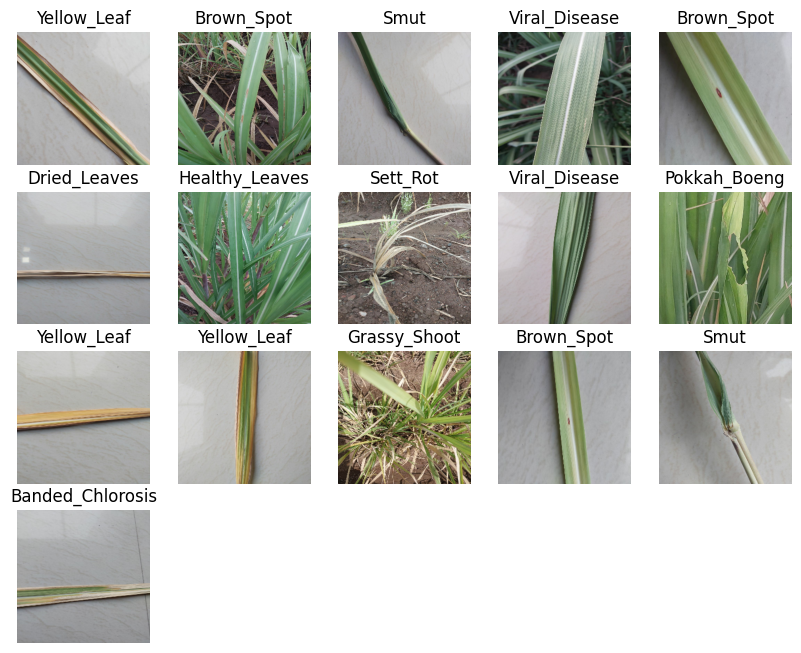

In [9]:
# To plot the image/ to show the image we can do

plt.figure(figsize=(10, 10))        #this is used to give a proper scale

for image_batch, lable_batch in dataset.take(1):     #here image_batch, lable_batch is inbuild function in tensorflow
                                                     #take(1) is refferded as one batch i.ie. is 64 images  
        
    for i in range(16):            #means only first 25 images out of batch of 64
        
        ax = plt.subplot(5, 5, i + 1)          #here we are providing row and colums to plot
        
        plt.imshow(image_batch[i].numpy().astype("uint8"))    #we are doing astype("uint8") because it is in float initialy 
                                                              #so to convert in int to plot as inputed

        plt.title(class_names[lable_batch[i]])            #we are doing this so that we can get the tile to the image 
                                                          #i.e. it is from which class  
                                                          #here we are supplying lable_batch as an index to class_name 
                                                          #so that we can see the names properly

        plt.axis("off")               #it will turn off the axis marking
    # It will plot diffrent images every time as we have used suffle

# #Till here we are done with the some king of visualizing part 

In [10]:
# Now to split dataset we can do it following way
# 80% for training
# 10% for validation
# 10% for testing
ts = int(len(dataset)*0.8)
vs = int(len(dataset)*0.1)
print("Total lenght of dataset : ", len(dataset))
print("80% for training : ", int(len(dataset)*0.8))
print("10% for validation : ", int(len(dataset)*0.1))
print("10% for testing : ", int(len(dataset) - (int(len(dataset)*0.8) + int(len(dataset)*0.1))))

Total lenght of dataset :  106
80% for training :  84
10% for validation :  10
10% for testing :  12


In [11]:
# Dividing the dataset

training_ds = dataset.take(ts)              #arr[:84]
remaining_ds = dataset.skip(ts)             #arr[84:]
validation_ds = remaining_ds.take(vs)
testing_ds = remaining_ds.skip(vs)

print("Lenght of training dataset : ", len(training_ds))
print("Lenght of validation dataset : ", len(validation_ds))
print("Lenght of testing dataset : ", len(testing_ds))

Lenght of training dataset :  84
Lenght of validation dataset :  10
Lenght of testing dataset :  12


In [12]:
# Now we will perform caching and prefetch and shuffle

# Cashing means, we are doing this so that one the image come from secondary storage to primary storage it will keep the image in it for 
# the next itreation so there is no need to again and again laod the image i.e. it will increase the performance of the pipeline

# Prefetch here means as we have multiple batch, if GPU is computing / training on the first batch, CPU will prefetch the next batch,
# so that it is faster and no one is sitting idealy

# Shuffle, here it means for the diffrent epoch it will shuffle / randomly select a image to train,
# here we are using shuffle(1000) this means it will have a / create a room of 1000 places know as buffer size and from that it will 
# pick any one ramdomly and one new image from the totale images in the room of 1000 and repate the task
# Example arr[1, 2, 3, 4, 5, 6] and shuffle buffer size is 3 :
#     <=   [1,2,3]   <=   [4,5,6]     #here it create a room and and took 2 number inside
# 2   <=   [1,3,4]   <=   [5,6]       #once it choosed a random number it filled it self with new number
# 1   <=   [3,4,5]   <=   [6]
# 5   <=   [3,4,6]   <=   []
# 3   <=   [4,6]     <=   []
# 6   <=   [4]       <=   []
# 4   <=   []        <=   []


training_ds = training_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
testing_ds = testing_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
#here prefetch(buffer_size=tf.data.AUTOTUNE) means we are giving CPU the count of batch it want to prepare / load / fetch while GPU is training 

# Now at this stage our data is kindly optimized for training performace so training will run fast

In [13]:
# Now we need to do some preprocessing like resizing and scaling the images andnn data augmentation

# Resizing and scaling the date, now here we have already resize the data above while importing it then why again, 
# this resizing and scaling data is for the later perpose like when we will click a photo for testing purpose that time the 
# image size will not be equal fo that we are resizing it again
# Scaling, as we all know that we got a numpy array above but it was between 0 225 as it a RGB scale but for 
# training and testing we perpose we need it between 0 and 1 

resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(iz, iz),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

# Data augmentation, we do this when we have less data, and also it increase the prediction accurace, what we do here is we 
# can rotate the image, can zoom the image, can cantrast the image, can flip the image and more.., what this does is make a diffrent 
# copies of the image using above factor helping us to train the data in all factor to make it more rumbust

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
])

In [14]:
# training_ds = training_ds.map(
#     lambda x, y: (data_augmentation(x, training=True), y)
# ).prefetch(buffer_size=tf.data.AUTOTUNE)

# plt.figure(figsize=(10, 10)) 
# for image_batch, lable_batch in training_ds.take(1):
#     for i in range(16):
#         ax = plt.subplot(5, 5, i + 1)
#         plt.imshow(image_batch[i].numpy().astype("uint8"))
#         plt.title(class_names[lable_batch[i]])
#         plt.axis("off")

In [16]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation = LeakyReLU(alpha=0.2), input_shape=(bs,iz,iz,3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation = LeakyReLU(alpha=0.2)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation = LeakyReLU(alpha=0.2)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = LeakyReLU(alpha=0.2)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = LeakyReLU(alpha=0.2)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = LeakyReLU(alpha=0.2)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = LeakyReLU(alpha=0.2)),
    layers.Dense(11, activation='softmax'),
])

model.build(input_shape=(bs,iz,iz,3))

In [17]:
# mixed_precision_policy = tf.keras.mixed_precision.Policy('mixed_float16')
# tf.keras.mixed_precision.set_policy(mixed_precision_policy)

# policy = tf.keras.mixed_precision.Policy('mixed_float16')
# tf.keras.mixed_precision.set_global_policy(policy)

# # Use LossScaleOptimizer
# optimizer = tf.keras.mixed_precision.LossScaleOptimizer(tf.keras.optimizers.Adam())


In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
history = model.fit(
    training_ds,
    batch_size=bs,
    validation_data=validation_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


84/84 [==============================] - 75s 587ms/step - loss: 2.1066 - accuracy: 0.2641 - val_loss: 1.9060 - val_accuracy: 0.3031
Epoch 2/50
84/84 [==============================] - 42s 498ms/step - loss: 1.5048 - accuracy: 0.4693 - val_loss: 1.3911 - val_accuracy: 0.4766
Epoch 3/50
84/84 [==============================] - 41s 490ms/step - loss: 1.2023 - accuracy: 0.5711 - val_loss: 1.1578 - val_accuracy: 0.5859
Epoch 4/50
84/84 [==============================] - 41s 484ms/step - loss: 1.0270 - accuracy: 0.6230 - val_loss: 1.2835 - val_accuracy: 0.5453
Epoch 5/50
84/84 [==============================] - 40s 481ms/step - loss: 0.8750 - accuracy: 0.6873 - val_loss: 1.5000 - val_accuracy: 0.4844
Epoch 6/50
84/84 [==============================] - 40s 479ms/step - loss: 0.7923 - accuracy: 0.7137 - val_loss: 1.0953 - val_accuracy: 0.6141
Epoch 7/50
84/84 [==============================] - 41s 486ms/step - loss: 0.7268 - accuracy: 0.7351 - val_loss: 1.0905 - val_accuracy: 0.6141
Epoch 8/50

In [ ]:
scores = model.evaluate(testing_ds)
scores

12/12 [==============================] - 6s 38ms/step - loss: 0.1616 - accuracy: 0.9235


[0.16155710816383362, 0.9234972596168518]

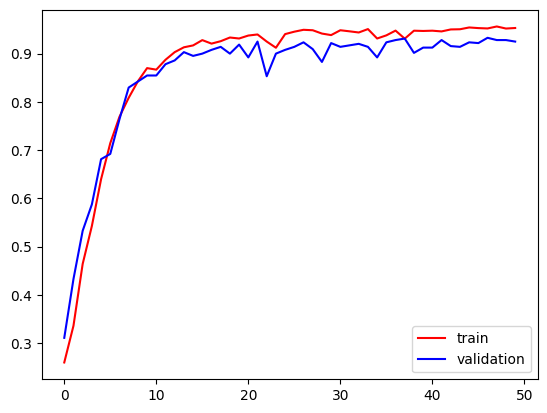

In [ ]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

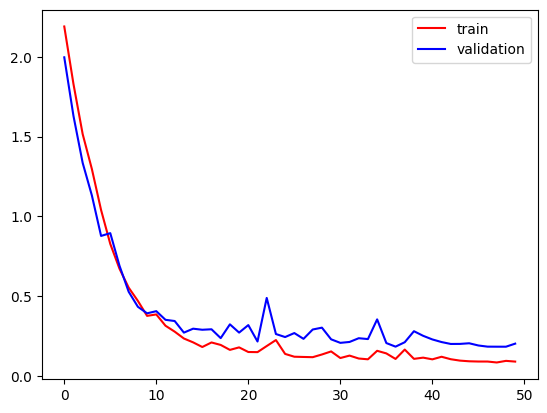

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

first image to predict
actual label: Pokkah_Boeng
predicted label: Pokkah_Boeng


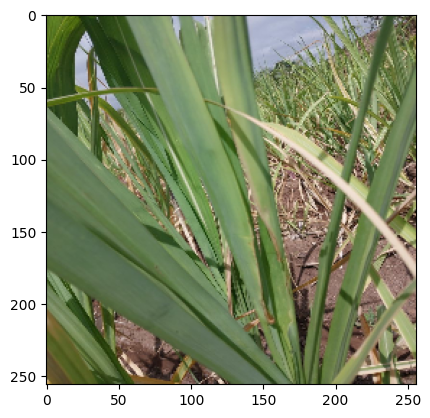

In [ ]:
import numpy as np
for images_batch, labels_batch in testing_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch, verbose=0)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

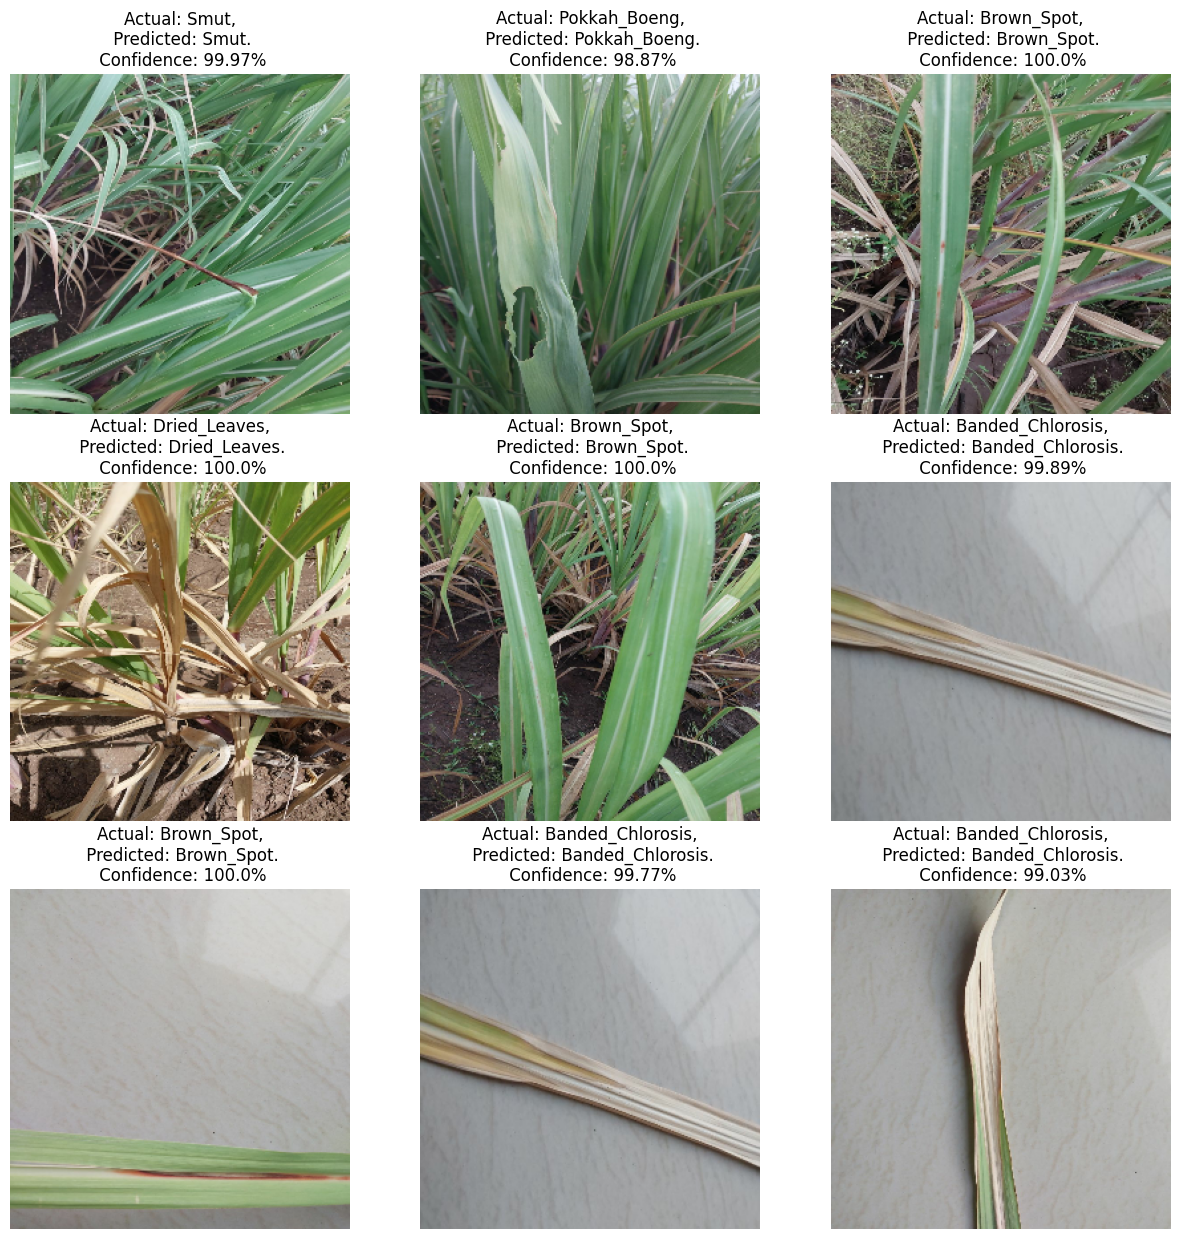

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array, verbose=0)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in testing_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
        

In [ ]:
model.save(f"../Models/Version_2")
loaded_model = models.load_model(f"../Models/Version_2")

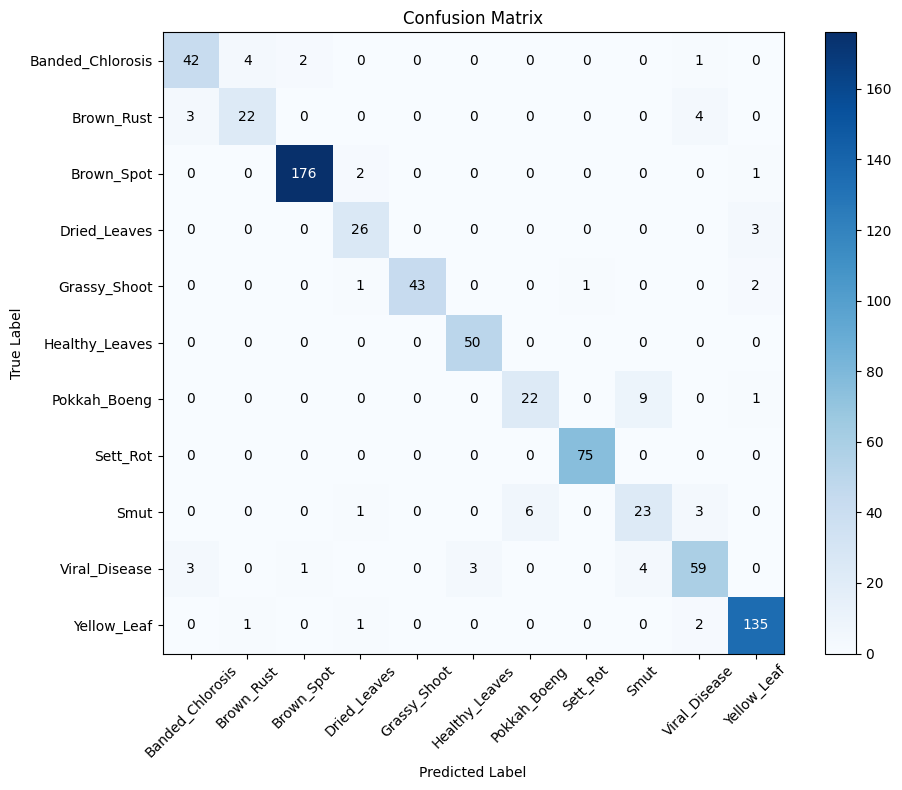

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Generate confusion matrix on testing dataset
y_true = []
y_pred = []
for images, labels in testing_ds:
    predictions = loaded_model.predict(images, verbose=0)
    predicted_labels = tf.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels.numpy())

# Create and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(11))
class_names = dataset.class_names

# Plot confusion matrix with colors
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(11)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)

# Add labels to each cell
thresh = cm.max() / 2.
for i in range(11):
    for j in range(11):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Create a list to store the true labels and predicted labels
y_true_test = []
y_pred_classes_test = []

# Iterate through the testing dataset to get true labels and predictions
for images, labels in testing_ds:
    y_true_test.extend(labels.numpy())
    predictions = loaded_model.predict(images, verbose=0)  # Replace 'your_model' with the actual model
    y_pred_classes_test.extend(np.argmax(predictions, axis=1))

# Convert the label indices to class names
class_names = dataset.class_names
y_true_class_names = [class_names[i] for i in y_true_test]
y_pred_class_names = [class_names[i] for i in y_pred_classes_test]

# Calculate and print the classification report
report_test = classification_report(y_true_class_names, y_pred_class_names, target_names=class_names)

print(report_test)

                  precision    recall  f1-score   support

Banded_Chlorosis       0.91      0.85      0.88        46
      Brown_Rust       0.89      0.80      0.85        41
      Brown_Spot       0.98      0.98      0.98       175
    Dried_Leaves       0.82      0.93      0.87        30
    Grassy_Shoot       1.00      0.93      0.97        45
  Healthy_Leaves       0.96      0.98      0.97        47
    Pokkah_Boeng       0.83      0.75      0.79        32
        Sett_Rot       0.99      1.00      0.99        83
            Smut       0.62      0.70      0.66        30
   Viral_Disease       0.84      0.87      0.85        70
     Yellow_Leaf       0.97      0.96      0.97       133

        accuracy                           0.92       732
       macro avg       0.89      0.89      0.89       732
    weighted avg       0.93      0.92      0.93       732



In [ ]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation = 'relu', input_shape=(bs,iz,iz,3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(11, activation='softmax'),
])

model.build(input_shape=(bs,iz,iz,3))

In [ ]:
model.summary()

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    training_ds,
    batch_size=bs,
    validation_data=validation_ds,
    verbose=1,
    epochs=50,
)

In [ ]:
scores = model.evaluate(testing_ds)
scores

In [ ]:
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

In [ ]:
import numpy as np
for images_batch, labels_batch in testing_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch, verbose=0)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array, verbose=0)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

plt.figure(figsize=(15, 15))
for images, labels in testing_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")
        

In [ ]:
model.save(f"../Models/Version_3")
loaded_model = models.load_model(f"../Models/Version_3")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Generate confusion matrix on testing dataset
y_true = []
y_pred = []
for images, labels in testing_ds:
    predictions = loaded_model.predict(images, verbose=0)
    predicted_labels = tf.argmax(predictions, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels.numpy())

# Create and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=range(11))
class_names = dataset.class_names

# Plot confusion matrix with colors
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(11)
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.grid(False)

# Add labels to each cell
thresh = cm.max() / 2.
for i in range(11):
    for j in range(11):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Create a list to store the true labels and predicted labels
y_true_test = []
y_pred_classes_test = []

# Iterate through the testing dataset to get true labels and predictions
for images, labels in testing_ds:
    y_true_test.extend(labels.numpy())
    predictions = loaded_model.predict(images, verbose=0)  # Replace 'your_model' with the actual model
    y_pred_classes_test.extend(np.argmax(predictions, axis=1))

# Convert the label indices to class names
class_names = dataset.class_names
y_true_class_names = [class_names[i] for i in y_true_test]
y_pred_class_names = [class_names[i] for i in y_pred_classes_test]

# Calculate and print the classification report
report_test = classification_report(y_true_class_names, y_pred_class_names, target_names=class_names)

print(report_test)